In [1]:
import scipy
from scipy.optimize import minimize
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import ad

<h2> Exercise 4 </h2>
<p> For tasks 1-3, we study the optimization problem: </p>

$$  \min \qquad x_1^2 + x_2^2 + x_1 + 2x_2 $$
$$\text{s.t.} \qquad \qquad x_1 + x_2 = 1 $$
$$\qquad \qquad \qquad x_1 \text{,} x_2 \in R $$

<h4> Task 1 </h4>
<p> We will solve the problem using the penalty function method </p>

<p> Let's first define $ x_1 + x_2 = 1 $ as $ x_1 + x_2 - 1 = 0 $</p> 

In [2]:
# Now we can define our function as follows:
def f(x):
    return x[0]**2 + x[1]**2 + x[0] + 2*x[1], [], [x[0] + x[1] - 1]

In [3]:
# Define alpha as (from lectures):
def alpha(x,f):
    (_,ieq,eq) = f(x)
    return sum([min([0,ieq_j])**2 for ieq_j in ieq]) + sum([eq_k**2 for eq_k in eq])

In [4]:
# Penalized function (from lectures):
def penalized(x,f,r):
    return f(x)[0] + r*alpha(x,f)

In [5]:
# Hint for this task was that we should not use r as fixed value
# So we cant just use:
#res = minimize(lambda x:penalized(x,f,r), x_old, method='Nelder-Mead')
# where r = some fixed number

# Let's make a loop and add 10 to r every time: 

r = 1 # We will start with r = 1
precision = 0.0001
a = np.array([float('inf')])
#starting point at -1,1
b = [-1,1]
steplist_penalty = []
iter0 = 0
while iter0 < 100:
    a = b
    res = minimize(lambda x:penalized(x,f,r), a, method='Nelder-Mead', options={'disp': False})
    b = np.array(res.x)
    r = r + 10
    iter0 = iter0 + 1
    steplist_penalty.append(list(b))
print("res: ", res)
print("Solution is: ", b[0], ",", b[1])
print("r: ", r)
print("iter: ", iter0)

res:   final_simplex: (array([[0.7493755 , 0.24936674],
       [0.74927764, 0.24946301],
       [0.74938422, 0.24934906]]), array([1.87342411, 1.87342412, 1.87342414]))
           fun: 1.873424113587993
       message: 'Optimization terminated successfully.'
          nfev: 43
           nit: 22
        status: 0
       success: True
             x: array([0.7493755 , 0.24936674])
Solution is:  0.749375503433799 , 0.24936673550903682
r:  1001
iter:  100


<h4> Task 2 </h4>
<p> We solve the problem (i.e., approximate the optimal solution) using the barrier function method. </p>
<p> For this to work we need to convert our equality constraint into an inequality constraint</p>

Let
$$ s ≥ 0 $$ 
be our slack variable.
So now we can define our inequalities as:
$$\qquad \qquad x_1 + x_2 - 1 - s ≤ 0 $$
$$\qquad \qquad  -x_1 - x_2 + 1 + s ≥ 0 $$

In [6]:
def f_ineq(x, s):
    return x[0]**2 + x[1]**2 + x[0] + 2*x[1], [x[0] + x[1] -1 + s, -x[0] - x[1] + 1 + s], []

In [7]:
# Define beta as (from lectures):
def beta(x,f):
    _,ieq,_ = f(x)
    try:
        value=sum([1/max([0,ieq_j]) for ieq_j in ieq])
    except ZeroDivisionError:
        value = float("inf")
    return value 

In [8]:
# Define barrier as (from lectures): 
def barrier(x,f,r):
    return f(x)[0] + r*beta(x,f)

In [9]:
s = 0.1 # Our slack variable
r = 1 # We will start with r = 1
precision = 0.0001
a = np.array([float('inf')])
#starting point at 10,-10
b = [10,-10]
steplist_barrier = []
iter1 = 0
while iter1 < 100:
    res = minimize(lambda x:barrier(x, lambda a:f_ineq(a,s), r),b,method='Nelder-Mead',options={'disp': False})
    a = b
    b = res.x
    r = r+1
    s = s/2
    steplist_barrier.append(list(b))
    iter1 = iter1 +1
print("res: ", res)
print("Solution is: ", b[0], ",", b[1])
print("iter: ", iter1)

res:   final_simplex: (array([[0.74991813, 0.25008187],
       [0.74991813, 0.25008187],
       [0.74991813, 0.25008187]]), array([1.2676506e+33, 1.2676506e+33, 1.2676506e+33]))
           fun: 1.2676506002282294e+33
       message: 'Optimization terminated successfully.'
          nfev: 198
           nit: 51
        status: 0
       success: True
             x: array([0.74991813, 0.25008187])
Solution is:  0.7499181304353058 , 0.25008186956469436
iter:  100


<h4> Task 3 </h4>
<p> We will solve the problem using the projected gradient method. </p>

In [10]:
#From lectures
def project_vector(A,vector):
    #convert A into a matrix
    A_matrix = np.matrix(A)
    #construct the "first row" of the matrix [[I,A^T],[A,0]]
    left_matrix_first_row = np.concatenate((np.identity(len(vector)),A_matrix.transpose()), axis=1)
    #construct the "second row" of the matrix
    left_matrix_second_row = np.concatenate((A_matrix,np.matrix(np.zeros([len(A),len(A)]))), axis=1)
    #combine the whole matrix by combining the rows
    left_matrix = np.concatenate((left_matrix_first_row,left_matrix_second_row),axis = 0)
    #Solve the system of linear equalities from the previous page
    return np.linalg.solve(left_matrix, \
                           np.concatenate((np.matrix(vector).transpose(),\
                                           np.zeros([len(A),1])),axis=0))[:len(vector)] 

In [11]:
#From lectures
def projected_gradient_method(f,A,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steplist_gradient = []
    f_new = f(x)
    iters = 0
    while abs(f_old-f_new)>precision:
        # store the current function value
        f_old = f_new
        # compute gradient
        gradient = ad.gh(f)[0](x)
        # project negative gradient
        d = project_vector(A,[-i for i in gradient])
        # take transpose
        d = d.reshape(1,-1)
        # take step
        x = np.array(x + step*d)[0]
        # compute f in new point+ 
        f_new = f(x)
        # record new step
        steplist_gradient.append(x)
        # update iterations counter
        iters = iters + 1
    return x,f_new,steplist_gradient,iters

In [12]:
A = [[1,1]]
start = [0,1]
(x,f_val,steps,iters) = projected_gradient_method(lambda x:f(x)[0],A,start,0.10,0.0001)
print(x)

[0.74135309 0.25864691]


<p> Now let's compare this to the performance of the penalty function used at task1 and barrier function methods from task 2

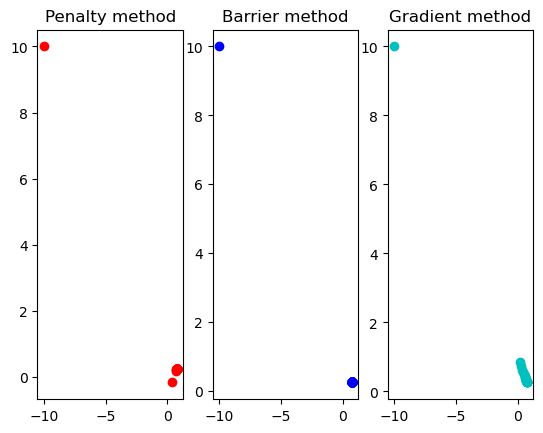

In [13]:
#Plotting functions steps
start = [-10,10]
#Plot of my function from task 1:
plt.subplot(1, 3, 1)
vector = np.array([start] + steplist_penalty).transpose()
plt.title("Penalty method")
plt.plot(vector[0,], vector[1,], 'ro')

plt.subplot(1, 3, 2)
vector1 = np.array([start] + steplist_barrier).transpose()
plt.title("Barrier method")
plt.plot(vector1[0,], vector1[1,], 'bo')

plt.subplot(1, 3, 3)
vector2 = np.array([start] + steps).transpose()
plt.title("Gradient method")
plt.plot(vector2[0,], vector2[1,], 'co')

plt.show()

<h4> Task 4 </h4>
<p> Let's check the necessary first-order KKT conditions for the solution. </p>

Let's define the Lagrangian function
$$ 𝐿(𝑥,𝜇,𝜆)=f(x)−𝜇_1h(x) - 𝜆_1g(x) $$
And we will get:
$$ 𝐿(𝑥,𝜇,𝜆)=(x_1^2 + x_2^2 + x_1 + 2x_2)−𝜇(0) - 𝜆(x_1 + x_2 - 1) $$

We need to solve a system of equations as:

$$
\begin{cases}
f_{x_1} = 𝜆g_{x_1}\\ 
f_{x_2} = 𝜆g_{x_2} 
\end{cases}
$$

Let's calculate the partial derivatives:

$$ \frac{\partial f}{\partial x_1} = 2x_1 + 1 $$
$$ $$
$$ \frac{\partial f}{\partial x_2} = 2x_2 + 2 $$

And then the partial derivatives for $g(x)$:

$$ \frac{\partial g}{\partial x_1} = 1 $$
$$ $$
$$ \frac{\partial g}{\partial x_2} = 1 $$

Thus we will get:
$$
\begin{cases}
2x_1 + 1 = 𝜆 \\ 
2x_2 + 2 = 𝜆  
\end{cases}
$$


In [33]:
res_penalty = [0.749375503433799,0.24936673550903682]
res_barrier = [0.7499181304353058 , 0.25008186956469436]
res_gradient = [0.74135309,0.25864691]
precision_penalty = 0.0001
precision_barrier = 0.001
precision_gradient = 0.1

lambdax1_penalty = 2*res_penalty[0] + 1
lambdax2_penalty = 2*res_penalty[1] + 2

lambdax1_barrier = 2*res_barrier[0] + 1
lambdax2_barrier = 2*res_barrier[1] + 2

lambdax1_gradient = 2*res_gradient[0] + 1
lambdax2_gradient = 2*res_gradient[1] + 2


if abs(lambdax2_penalty - lambdax1_penalty) <= precision_penalty:
    print("Penalty method with precision of: ", precision_penalty, "is correct")
else:
    print("Penalty method with precision of: ", precision_penalty, "is not correct")
    
    
if abs(lambdax2_barrier - lambdax1_barrier) <= precision_barrier:
    print("Barrier method with precision of: ", precision_barrier, "is correct")
else:
    print("Barrier method with precision of: ", precision_barrier, "is not correct")
    
    
if abs(lambdax2_gradient - lambdax1_gradient) <= precision_gradient:
    print("Gradient method with precision of: ", precision_gradient, "is correct")
else:
    print("Gradient method with precision of: ", precision_gradient, "is not correct")

Penalty method with precision of:  0.0001 is correct
Barrier method with precision of:  0.001 is correct
Gradient method with precision of:  0.1 is correct
